<a href="https://colab.research.google.com/github/aasem/cvisionmcs/blob/main/mlp_vanilla_ann_explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import shutil
#shutil.rmtree('/content/cvisionmcs')
!git clone https://github.com/aasem/cvisionmcs

Cloning into 'cvisionmcs'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (200/200), done.
remote: Compressing objects: 100% (186/186), done.
remote: Total 200 (delta 69), reused 3 (delta 0), pack-reused 0
Receiving objects: 100% (200/200), 7.51 MiB | 19.03 MiB/s, done.
Resolving deltas: 100% (69/69), done.


# Implement a Generalized Two Layer ANN (from Scratch)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

class TwoLayerNet(object):
  """
  - input dimension N
  - hidden layer dimension H
  - perfomrs classification over C classes

  - Training Parameters
  -- Loss function: softmax
  -- Regularization: L2
  -- Activation Nonlinearity: ReLU
  
  - Network Architecture
    input - fully connected layer - ReLU - fully connected layer - softmax
    The outputs of the second fully-connected layer are the scores for each class.
  """

  def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    """
    Initialize the model. Weights are initialized to small random values and
    biases are initialized to zero. Weights and biases are stored in the
    variable self.params, which is a dictionary with the following keys:
    W1: First layer weights; has shape (D, H)
    b1: First layer biases; has shape (H,)
    W2: Second layer weights; has shape (H, C)
    b2: Second layer biases; has shape (C,)

    Inputs:
    - input_size: The dimension D of the input data.
    - hidden_size: The number of neurons H in the hidden layer.
    - output_size: The number of classes C.
    """
    self.params = {}
    self.params['W1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def loss(self, X, y=None, reg=0.0):
    """
    Compute the loss and gradients for a two layer fully connected neural
    network.
    Inputs:
    - X: Input data of shape (N, D). Each X[i] is a training sample.
    - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] < C. This parameter is optional; if it
      is not passed then we only return scores, and if it is passed then we
      instead return the loss and gradients.
    - reg: Regularization strength.
    Returns:
    If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
    the score for class c on input X[i].
    If y is not None, instead return a tuple of:
    - loss: Loss (data loss and regularization loss) for this batch of training
      samples.
    - grads: Dictionary mapping parameter names to gradients of those parameters
      with respect to the loss function; has the same keys as self.params.
    """
    # Unpack variables from the params dictionary
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    N, D = X.shape

    # Compute the forward pass
    # shape of scores array (N, C)
    scores = None
    fc1 = X.dot(W1) + b1     # fully connected
    X2 = np.maximum(0, fc1)  # ReLU
    scores = X2.dot(W2) + b2 # fully connected
    
    # If the targets are not given then jump out, we're done
    if y is None:
      return scores

    # Compute the loss which is scalar
    loss = None
    scores -= np.max(scores, axis=1, keepdims=True) # avoid numeric instability
    scores_exp = np.exp(scores)
    softmax_matrix = scores_exp / np.sum(scores_exp, axis=1, keepdims=True) 
    loss = np.sum(-np.log(softmax_matrix[np.arange(N), y]))
    loss /= N
    loss += reg * (np.sum(W2 * W2) + np.sum( W1 * W1 )) # regularization
  
  
    # Backward pass: compute gradients
    grads = {} #dictionary
    softmax_matrix[np.arange(N) ,y] -= 1
    softmax_matrix /= N

    # W2 gradient
    dW2 = X2.T.dot(softmax_matrix)   # [HxN] * [NxC] = [HxC]

    # b2 gradient
    db2 = softmax_matrix.sum(axis=0)

    # W1 gradient
    dW1 = softmax_matrix.dot(W2.T)   # [NxC] * [CxH] = [NxH]
    dfc1 = dW1 * (fc1>0)             # [NxH] . [NxH] = [NxH]
    dW1 = X.T.dot(dfc1)              # [DxN] * [NxH] = [DxH]

    # b1 gradient
    db1 = dfc1.sum(axis=0)

    # regularization gradient
    dW1 += reg * 2 * W1
    dW2 += reg * 2 * W2

    grads = {'W1':dW1, 'b1':db1, 'W2':dW2, 'b2':db2}

    return loss, grads

  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this neural network using stochastic gradient descent.
    Inputs:
    - X: A numpy array of shape (N, D) giving training data.
    - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
      X[i] has label c, where 0 <= c < C.
    - X_val: A numpy array of shape (N_val, D) giving validation data.
    - y_val: A numpy array of shape (N_val,) giving validation labels.
    - learning_rate: Scalar giving learning rate for optimization.
    - learning_rate_decay: Scalar giving factor used to decay the learning rate
      after each epoch.
    - reg: Scalar giving regularization strength.
    - num_iters: Number of steps to take when optimizing.
    - batch_size: Number of training examples to use per step.
    - verbose: boolean; if true print progress during optimization.
    """

    num_train = X.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)

    # Use SGD to optimize the parameters in self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in range(num_iters):
      X_batch = None
      y_batch = None

      # a random minibatch of training data and labels, storing 
      # them in X_batch and y_batch respectively.                             #
      batch_indices = np.random.choice(num_train, batch_size)
      X_batch = X[batch_indices]
      y_batch = y[batch_indices]
      
      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
      loss_history.append(loss)

      # Using the gradients in the grads dictionary to update the
      # parameters of the network (stored in the dictionary self.params)      
      # using stochastic gradient descent. We'll need to use the gradients   
      # stored in the grads dictionary defined above.                         
      
      for key in self.params:
        self.params[key] -= learning_rate * grads[key]
      

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(X_batch) == y_batch).mean()
        val_acc = (self.predict(X_val) == y_val).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Decay learning rate
        learning_rate *= learning_rate_decay

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, X):
    """
    Use the trained weights of this two-layer network to predict labels for
    data points. For each data point we predict scores for each of the C
    classes, and assign each data point to the class with the highest score.
    Inputs:
    - X: A numpy array of shape (N, D) giving N D-dimensional data points to
      classify.
    Returns:
    - y_pred: A numpy array of shape (N,) giving predicted labels for each of
      the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
      to have class c, where 0 <= c < C.
    """
    y_pred = None
    y_pred = np.argmax( self.loss(X), axis=1)
    
    return y_pred

## Sanity Check (Toy Model)

We will use the above class ```TwoLayerNet```  to represent instances of our network. The network parameters are stored in the instance variable ```self.params``` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop our implementation.

In [3]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

**Train the Nerwork**

iteration 0 / 100: loss 1.241994
Final training loss:  0.017149607938732093


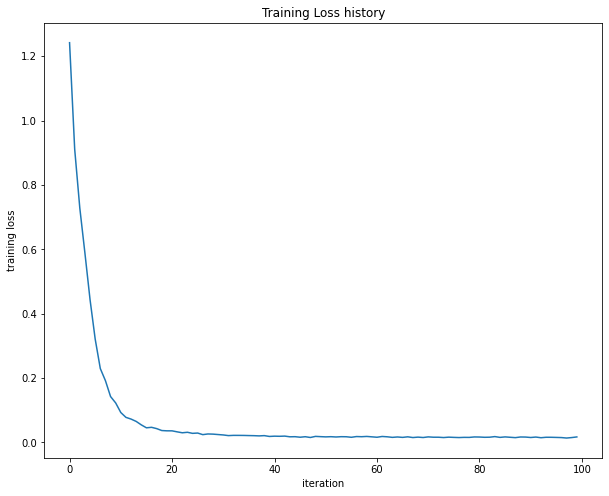

In [4]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=True)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

## Classify CIFAR10 with 2-Layer MLP

In [5]:
import matplotlib.pyplot as plt
from cvisionmcs import data_utils
from cvisionmcs import download
%matplotlib inline

In [6]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
download_dir = "./data"
download.maybe_download_and_extract(url,download_dir)

- Download progress: 100.0%
Download finished. Extracting files.
Done.


**Get the Preprocessed Data Using a Helper Function**

In [15]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = './data/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = data_utils.load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


## Training the Network
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [16]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10

net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1000: loss 2.302959
iteration 100 / 1000: loss 2.302544
iteration 200 / 1000: loss 2.297922
iteration 300 / 1000: loss 2.270157
iteration 400 / 1000: loss 2.200215
iteration 500 / 1000: loss 2.124357
iteration 600 / 1000: loss 2.055178
iteration 700 / 1000: loss 2.107270
iteration 800 / 1000: loss 2.064814
iteration 900 / 1000: loss 1.966962
Validation accuracy:  0.281


## Debug the Training Process

With these parameters, we should get a validation accuracy of about 27% on the validation set. This obviously isn't very good. There are two strategies to move forward from here.

**Strategy 1:** Plot the loss function and the accuracies on the training and validation sets during optimization. This will give insight into what might be wrong.

**Strategy 2:** Visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

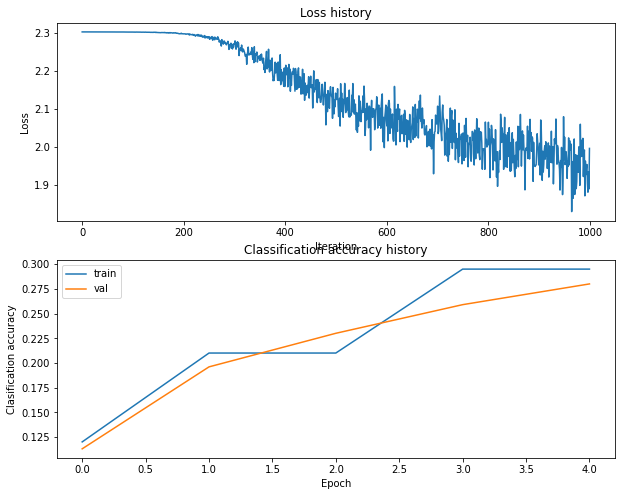

In [17]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

**What's wrong?** Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. 

On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

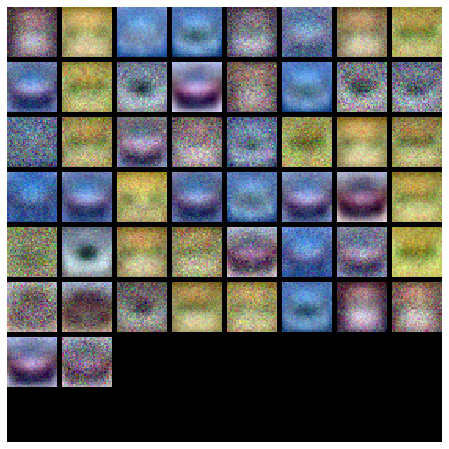

In [18]:
from cvisionmcs.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

## Hyperparameter Tuning
Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

In [19]:
# Tuning hyperparameters using the validation set. Best trained model stored in best_net.

best_net = None # store the best model into this 
best_val = -1
best_stats = []

# generate random hyperparameters given ranges for each of them
def generate_random_hyperparams(lr_min, lr_max, reg_min, reg_max, h_min, h_max):
    lr = 10**np.random.uniform(lr_min,lr_max)
    reg = 10**np.random.uniform(reg_min,reg_max)
    hidden = np.random.randint(h_min, h_max)
    return lr, reg, hidden

# get random hyperparameters given arrays of potential values
def random_search_hyperparams(lr_values, reg_values, h_values):
    lr = lr_values[np.random.randint(0,len(lr_values))]
    reg = reg_values[np.random.randint(0,len(reg_values))]
    hidden = h_values[np.random.randint(0,len(h_values))]
    return lr, reg, hidden

input_size = 32 * 32 * 3
num_classes = 10

# Set a seed for results reproduction
np.random.seed(0)

# Use of random search for hyperparameter search
for i in range(20):
    ## Strategy to find the best hyperparameters over 52% on the validation set
    # Use generate_random function given some interval with 500 iterations
    #lr, reg, hidden_size = generate_random_hyperparams(-6, -3, -5, 5, 20, 3000)
    #lr, reg, hidden_size = generate_random_hyperparams(-4, -2, -2, 2, 20, 3000)
    #lr, reg, hidden_size = generate_random_hyperparams(-4, -3, -1, 0, 10, 300)
    
    # According to the previous results, reduce the exploration by selecting set of fixed ranges
    # use this ranges in the random search function to explore random combinations
    #lr, reg, hidden_size = random_search_hyperparams([0.001, 0.002, 0.003], [0.1, 0.2, 0.3, 0.4, 0.5], [10, 50, 100, 150, 200])
    #lr, reg, hidden_size = random_search_hyperparams([0.001], [0.1, 0.15, 0.2, 0.3], [10, 20, 30, 40 ,50, 80, 100, 150 , 200])    
    
    # Given a set of potential values, increase the number of iterations
    lr, reg, hidden_size = random_search_hyperparams([0.001], [0.05, 0.1, 0.15], [50, 80, 100, 120, 150, 180, 200])
    
    # Create a two-layer network
    net = TwoLayerNet(input_size, hidden_size, num_classes)
    
    # Train the network
    stats = net.train(X_train, y_train, X_val, y_val,
                num_iters=2000, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=False)

    # Predict on the training set
    train_accuracy = (net.predict(X_train) == y_train).mean()
    
    # Predict on the validation set
    val_accuracy = (net.predict(X_val) == y_val).mean()
    
    # Save best values
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_net = net
        best_stats = stats
    
    # Print results
    print('lr %e reg %e hid %d  train accuracy: %f val accuracy: %f' % (
                lr, reg, hidden_size, train_accuracy, val_accuracy))
print('best validation accuracy achieved: %f' % best_val)

lr 1.000000e-03 reg 5.000000e-02 hid 180  train accuracy: 0.566061 val accuracy: 0.491000
lr 1.000000e-03 reg 1.500000e-01 hid 200  train accuracy: 0.571510 val accuracy: 0.521000
lr 1.000000e-03 reg 1.500000e-01 hid 80  train accuracy: 0.539163 val accuracy: 0.500000
lr 1.000000e-03 reg 1.000000e-01 hid 80  train accuracy: 0.555327 val accuracy: 0.524000
lr 1.000000e-03 reg 1.500000e-01 hid 100  train accuracy: 0.554510 val accuracy: 0.517000
lr 1.000000e-03 reg 5.000000e-02 hid 150  train accuracy: 0.575531 val accuracy: 0.515000
lr 1.000000e-03 reg 1.000000e-01 hid 150  train accuracy: 0.566755 val accuracy: 0.509000
lr 1.000000e-03 reg 1.500000e-01 hid 180  train accuracy: 0.567857 val accuracy: 0.522000
lr 1.000000e-03 reg 5.000000e-02 hid 120  train accuracy: 0.566000 val accuracy: 0.518000
lr 1.000000e-03 reg 1.500000e-01 hid 200  train accuracy: 0.568816 val accuracy: 0.514000
lr 1.000000e-03 reg 1.500000e-01 hid 150  train accuracy: 0.562633 val accuracy: 0.516000
lr 1.000000e

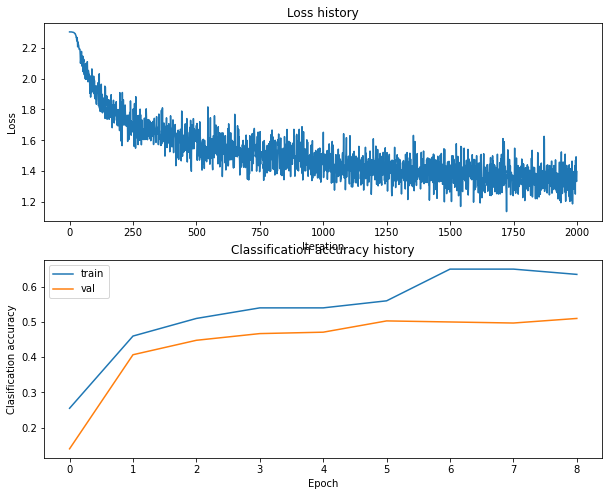

In [20]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

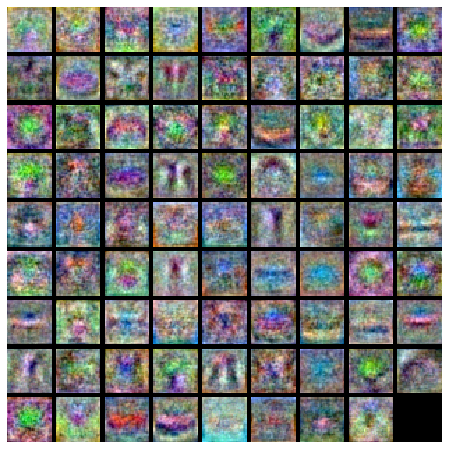

In [21]:
# visualize the weights of the best network
show_net_weights(best_net)